In [1]:
# This are just sample imports from a torch project of mine, change as necessary
from __future__ import print_function, division
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

!pip install transformers
from transformers import BertTokenizer, TFBertModel

from tokenizers import BertWordPieceTokenizer

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# for MNLI data set
from datasets import load_dataset

import time
import os
import copy

Defaulting to user installation because normal site-packages is not writeable


2023-02-01 15:14:09.241783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 15:14:10.598110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-01 15:14:10.598254: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-01 15:14:10.598261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# load data

In [2]:
PATH = ""

train = pd.read_csv(os.path.join(PATH, 'train.csv'))
validation = pd.read_csv(os.path.join(PATH, 'test.csv'))
validation_labels = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

In [3]:
validation = validation.drop(validation[~(validation['lang_abv'] == 'en')].index)
validation_labels = validation_labels[validation_labels['id'].isin(validation['id'])]

# Data exploration

In [4]:
display(train.head())
display(train.shape)

display(validation.head())
display(validation.shape)

display(validation_labels.head())
display(validation_labels.shape)
counts = validation_labels['prediction'].value_counts()
display(counts)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


(12120, 6)

,id,premise,hypothesis,lang_abv,language
5,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,en,English
6,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,en,English
8,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,en,English
10,f11f1ffffe,how long has he been in his present position,What length of time has he held the current po...,en,English
12,40a9b0f08e,Research and development is composed of,R&D is made up of.,en,English


(2945, 5)

,id,prediction
5,aa2510d454,1
6,865d1c7b16,1
8,6d9fa191e6,1
10,f11f1ffffe,1
12,40a9b0f08e,1


(2945, 2)

1    2945
Name: prediction, dtype: int64

# Filtering Datasets to only Keep English

In [5]:
train = train.drop(train[~(train['lang_abv'] == 'en')].index)
validation = validation.drop(validation[~(validation['lang_abv'] == 'en')].index)
validation_labels = validation_labels[validation_labels['id'].isin(validation['id'])]

display(train.head())
display(validation.head())
display(validation_labels.head())

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
7,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2
8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1


,id,premise,hypothesis,lang_abv,language
5,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,en,English
6,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,en,English
8,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,en,English
10,f11f1ffffe,how long has he been in his present position,What length of time has he held the current po...,en,English
12,40a9b0f08e,Research and development is composed of,R&D is made up of.,en,English


,id,prediction
5,aa2510d454,1
6,865d1c7b16,1
8,6d9fa191e6,1
10,f11f1ffffe,1
12,40a9b0f08e,1


# Hyperparameter

In [6]:
EPOCHS = 100
BATCH_SIZE = 256
MAX_LEN = 100
PATIENCE = 5
LEARNING_RATE = 1e-5

# Load Tokenizer

In [7]:
import pickle5 as pickle

TOKENIZER_PATH = ""
# loading
with open(os.path.join(TOKENIZER_PATH,'tokenizer.pickle'), 'rb') as handle:
    tokenizer = pickle.load(handle)

# encoding sequence

In [8]:
def encode(df, tokenizer, max_len=100):
    pairs = df[['premise', 'hypothesis']].values.tolist()
    
    #check "BertTokenizer" do_lower_case = true
    tokenizer.enable_truncation(max_len)
    tokenizer.enable_padding()
    
    enc_list = tokenizer.encode_batch(pairs)
    input_word_ids = tf.ragged.constant([enc.ids for enc in enc_list], dtype=tf.int32)
    input_mask = tf.ragged.constant([enc.attention_mask for enc in enc_list], dtype=tf.int32)
    input_type_ids = tf.ragged.constant([enc.type_ids for enc in enc_list], dtype=tf.int32)
    
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask.to_tensor(),
        'input_type_ids': input_type_ids.to_tensor()}
    
    return inputs 


## load model

In [9]:
def build_model(model_name, model_class, max_len=50, add_input_type=False):
    tf.random.set_seed(123)
    
    encoder = model_class.from_pretrained(model_name)
    
    input_word_ids = tf.keras.Input(shape=(max_len,),
                                    dtype=tf.int32,
                                    name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,),
                                dtype=tf.int32,
                                name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,),
                                    dtype=tf.int32,
                                    name="input_type_ids")
    
    if add_input_type:
        features = encoder([input_word_ids, input_mask, input_type_ids])[0]
    else:
        features = encoder([input_word_ids, input_mask])[0]
    
    vector = tf.keras.layers.GlobalAveragePooling1D()(features)
    vector = tf.keras.layers.Dense(32, activation='relu')(vector)
    vector = tf.keras.layers.Dropout(0.5)(vector)
   
    output = tf.keras.layers.Dense(3, activation="softmax")(vector) 

    if add_input_type:
        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    else:
        model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
        
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

In [10]:
model_class = TFBertModel
tokenizer_class = BertTokenizer
model_name ='bert-base-uncased'

new_model = build_model(model_name,
                        model_class,
                        MAX_LEN,
                        add_input_type=True)

2023-02-01 15:14:27.179027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-01 15:14:27.318316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-01 15:14:27.318342: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-01 15:14:27.319191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep

In [11]:
new_model.load_weights('bert_best_checkpoint.hdf5')

# Testing validation set

In [12]:
validation_input = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)
validation_predictions = [np.argmax(i) for i in new_model.predict(validation_input)]
validation['prediction'] = validation_predictions
validation_labels.head()

93/93 [==============================] - 239s 3s/step


,id,prediction
5,aa2510d454,1
6,865d1c7b16,1
8,6d9fa191e6,1
10,f11f1ffffe,1
12,40a9b0f08e,1


In [13]:
validation = validation.reset_index()
validation = validation.drop(columns=['index'])
display(validation.head())

validation_labels = validation_labels.reset_index()
validation_labels = validation_labels.drop(columns=['index'])
display(validation_labels.head())

,id,premise,hypothesis,lang_abv,language,prediction
0,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,en,English,1
1,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,en,English,1
2,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,en,English,1
3,f11f1ffffe,how long has he been in his present position,What length of time has he held the current po...,en,English,0
4,40a9b0f08e,Research and development is composed of,R&D is made up of.,en,English,0


,id,prediction
0,aa2510d454,1
1,865d1c7b16,1
2,6d9fa191e6,1
3,f11f1ffffe,1
4,40a9b0f08e,1


In [14]:
sum = 0 
size = validation.shape[0]
for i in range(size):
    sum = sum + (validation['prediction'][i] == validation_labels['prediction'][i])
print("Correct:", sum)
print("Total:", size)
print("Accuracy:", sum/size)

Correct: 954
Total: 2945
Accuracy: 0.3239388794567063


# Confusion Matrix

In [15]:
validation = validation.drop(columns=['id', 'premise', 'hypothesis','lang_abv', 'language'])
validation_labels = validation_labels.drop(columns=['id'])

In [16]:
display(validation.head())
display(validation_labels.head())

,prediction
0,1
1,1
2,1
3,0
4,0


,prediction
0,1
1,1
2,1
3,1
4,1



Classification Report
               precision    recall  f1-score   support

contradiction       0.00      0.00      0.00         0
   entailment       0.00      0.00      0.00         0
      neutral       1.00      0.32      0.49      2945

     accuracy                           0.32      2945
    macro avg       0.33      0.11      0.16      2945
 weighted avg       1.00      0.32      0.49      2945



/home/yichen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yichen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yichen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


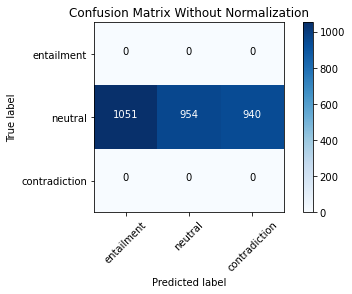

In [17]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import product

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm_plot_labels = ['entailment','neutral', 'contradiction']
cm = confusion_matrix(y_true=validation_labels, y_pred=validation_predictions)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix Without Normalization')

target_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in validation_labels['prediction']]
prediction_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in validation_predictions]

print('\nClassification Report')
print(classification_report(y_true=target_class, y_pred=prediction_class))